In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

### Preprocessing origin data

In [2]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    return X, y

def signal_cyclic_shift(signal, tau):
    signal_start = signal[:-tau]
    
    new_signal = np.concatenate([signal[-tau:], signal_start])
    
    return new_signal

In [3]:
X_origin, y_origin = get_data()

X_origin = np.array([experiment - np.max(experiment) for experiment in X_origin])
X_origin = np.array([experiment/-np.min(experiment) for experiment in X_origin])

y_origin = np.round(y_origin)
y_origin = y_origin.astype(int)

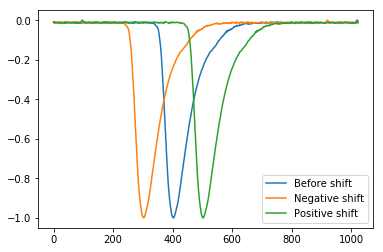

In [4]:
plt.plot(X_origin[0])
plt.plot(signal_cyclic_shift(X_origin[0], -100))
plt.plot(signal_cyclic_shift(X_origin[0], 100))

plt.legend(['Before shift', "Negative shift", "Positive shift"])
plt.show()

##### Let's shift each signal so that reference time matches for each signal

Mean reference time = 166.74566768603466


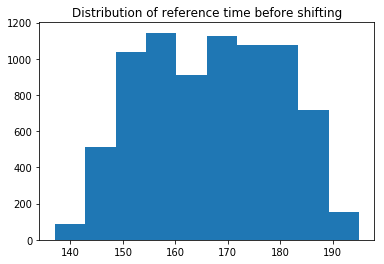

In [5]:
plt.title("Distribution of reference time before shifting")
plt.hist(y_origin)
mean_ref_time = int(y_origin.mean())
print("Mean reference time =", y_origin.mean())

In [6]:
X_origin = np.array([signal_cyclic_shift(signal, mean_ref_time - y_origin[i]) for i, signal in enumerate(X_origin, 0)])

### Generating multi signals

#### We will generate the signal the following way:
#### We have already shifted all the signals, so that they have the same reference time,
#### new signal will be calculated as first_signal*alpha + second_signal,
#### then normalization will be applied to new_signal, so that the impulse is in range from 0 to -1,
#### after that the first signal, the second signal and the new signal will be shifted, so that the location of minimum
#### of impulse matches for all of three signals
#### -----------------------------------------------------------------------------------------------
#### Let's figure out the location of minimum we will shift our signals to:

Mean argmin = 384.20412844036696


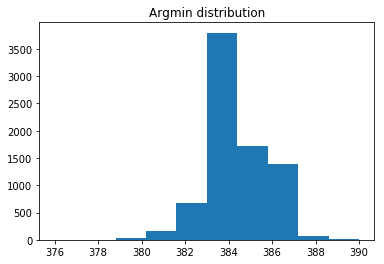

In [7]:
plt.title("Argmin distribution")
plt.hist(np.argmin(X_origin, axis=1))
mean_argmin =  int(np.argmin(X_origin, axis=1).mean())
print("Mean argmin =", np.argmin(X_origin, axis=1).mean())

In [8]:
a, b = np.random.choice(y_origin.shape[0], 2, replace=False)

In [9]:
def generate_multi_signal(tau, alpha, to_plot=False):
    first_idx, second_idx = np.random.choice(y_origin.shape[0], 2, replace=False)
    first_impulse = X_origin[first_idx]
    second_impulse = X_origin[second_idx]
    
    second_impulse = signal_cyclic_shift(second_impulse, tau)
    
    multi_impulse = first_impulse + second_impulse*alpha
    multi_impulse /= -np.min(multi_impulse)
    
    first_impulse_shifted = signal_cyclic_shift(first_impulse, mean_argmin - np.argmin(first_impulse))
    second_impulse_shifted = signal_cyclic_shift(second_impulse, mean_argmin - np.argmin(second_impulse))
    multi_impulse_shifted = signal_cyclic_shift(multi_impulse, mean_argmin - np.argmin(multi_impulse))

    if to_plot:
        plt.plot(first_impulse_shifted)
        plt.plot(second_impulse_shifted)
        plt.plot(multi_impulse_shifted)
        plt.legend(['First signal', 'Second signal', 'Sum of signals'])
        plt.show()
        
    return {'first': first_impulse_shifted,\
            'second': second_impulse_shifted,\
            'multi': multi_impulse_shifted}

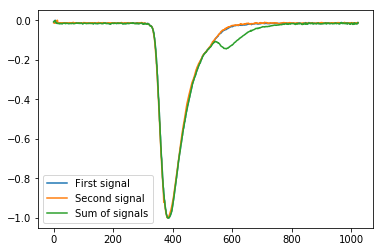

{'first': array([-0.00702908, -0.00698422, -0.00444043, ..., -0.01598683,
        -0.015282  , -0.01142465]),
 'second': array([-0.01254405, -0.01254405, -0.01423376, ..., -0.01494356,
        -0.01400763, -0.01273249]),
 'multi': array([-0.00858361, -0.00860468, -0.0060346 , ..., -0.01743787,
        -0.01667621, -0.01281619])}

In [10]:
generate_multi_signal(200, 0.1, to_plot=True)

##### Fixate tau and alpha parameters

In [11]:
tau = 0
alpha = 0.0001

### Preparing data

In [36]:
from sklearn.utils import shuffle

def prepare_data(tau, alpha, data_size=3000, to_print=False):
    data_size = 2000
    pos_size = int(data_size/2)
    neg_size = data_size - pos_size
    
    X_positive = np.array([generate_multi_signal(tau, alpha)['first'] for i in range(pos_size)])
    y_positive = np.ones(pos_size)
    
    X_negative = np.array([generate_multi_signal(tau, alpha)['multi'] for i in range(neg_size)])
    y_negative = np.zeros(neg_size)
    
    X = np.concatenate([X_positive, X_negative])
    y = np.concatenate([y_positive, y_negative])
   
    if to_print:
        print("X positive shape:", X_positive.shape)
        print("y positive shape:", y_positive.shape)
        print("X negative shape:", X_negative.shape)
        print("y negative shape:", y_negative.shape)
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

    return X, y

In [13]:
X, y = prepare_data(tau, alpha, to_print=True)

X positive shape: (250, 1024)
y positive shape: (250,)
X negative shape: (250, 1024)
y negative shape: (250,)
X shape: (500, 1024)
y shape: (500,)


### Splitting our data for train and test

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

print("X_train.shape:", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train.shape: (350, 1024)
y_train.shape (350,)
X_test shape: (150, 1024)
y_test shape: (150,)


### Ensemble

In [15]:
from scipy.stats import rankdata
from itertools import cycle
from sklearn.base import BaseEstimator, ClassifierMixin

class ShuffleVoter(BaseEstimator, ClassifierMixin):  
    """
       scikit-learn based voting aggregation ensembling.
       Using bootstrapping creates a set of models, differing only by which data sample they are fed
       """

    def __init__(self, models):
        """
        model - base model ( or a pipeline ) ( unfitted )
        """
        self.models = models
        
    def ensemble_predictions(self, predictions, weights, type_="harmonic"):
        """
        Combines probabilistic class estimates using a variety of strategies.
        Linear, harmonic, geometric and rank averaging are supported at this moment. 
        Insipred by well known Abhishek's kernel on Kaggle 
        model - base model ( or a pipeline ) ( unfitted )
        """
        assert np.isclose(np.sum(weights), 1.0)
        if type_ == "linear":
            res = np.average(predictions, weights=weights, axis=0)
        elif type_ == "harmonic":
            res = np.average([1 / p for p in predictions], weights=weights, axis=0)
            return 1 / res
        elif type_ == "geometric":
            numerator = np.average(
                [np.log(p) for p in predictions], weights=weights, axis=0
            )
            res = np.exp(numerator / sum(weights))
            return res
        elif type_ == "rank":
            res = np.average([rankdata(p) for p in predictions], weights=weights, axis=0)
            return res / (len(res) + 1)
        return res


    def fit( self, X, y, n_boots = 14, test_size = 100 ):
        """
        n_boots - number of bootstrapping iterations ( and respective models built)
        """
        self.clfs  = []
        for i, model in zip(range(n_boots), cycle(self.models)):
            X_tr, X_te, y_tr, y_te = train_test_split( X, y, test_size=test_size, random_state=3521 + i*11)

            pa_clf = model
            pa_clf.fit(X_tr, y_tr)

            self.clfs.append(pa_clf)

    def predict( self, X, ensemble_type = 'rank'):
        # TODO: nonuniform weights
        
        n_boots = len( self.clfs)
        preds = [ clf.predict(X) for clf in self.clfs ]
#         return self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type)
        return np.round(self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type))

    
    def predict_proba( self, X, ensemble_type = 'rank' ):
        n_boots = len( self.clfs)
        preds = [ clf.predict_proba(X) for clf in self.clfs ]
        return self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type)


### Defining pipelines

In [16]:
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [17]:
def get_pipelines(hyperparams = {'svc_c': 0.1, 'mlp_max_iter': 1000, 'kn_n': 5, 'pa_c': 0.0001}):
    SVC_pipeline = Pipeline([
                    ('clf', LinearSVC(C=hyperparams['svc_c'])),
                ])


    MLP_pipeline = Pipeline([
                    ('clf', MLPClassifier(max_iter=hyperparams['mlp_max_iter'])),
                ])

    KN_pipeline = Pipeline([
                    ('clf', KNeighborsClassifier(n_neighbors=hyperparams['kn_n'])),
                ])
    
    PA_pipeline = Pipeline([
                ('clf', PassiveAggressiveClassifier(C = hyperparams['pa_c'], max_iter=5000, tol=1e-3)),
            ])

    pipelines = {'svc': SVC_pipeline, 'kn': KN_pipeline, 'pa': PA_pipeline,  'mlp': MLP_pipeline}
    
    return pipelines

In [18]:
pipelines = get_pipelines()

### Pipelines scores:

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [20]:
del pipelines['mlp']

In [73]:
pipelines

for model_name, model in pipelines.items():
    print("Model name:", model_name)
    
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
    scores = cross_validate(model, X, y, scoring=scoring, cv=10)
    for score in scoring.keys():
        print(score, "%0.5f (+/- %0.5f)" % (scores["test_" + score].mean(), scores["test_" + score].std() * 2))
    print('------------------------------')

Model name: svc
accuracy 0.49360 (+/- 0.02477)
precision 0.49337 (+/- 0.02533)
recall 0.47760 (+/- 0.04003)
f1_score 0.48523 (+/- 0.03017)
------------------------------
Model name: kn
accuracy 0.50160 (+/- 0.05802)
precision 0.50133 (+/- 0.06108)
recall 0.47520 (+/- 0.07705)
f1_score 0.48774 (+/- 0.06771)
------------------------------
Model name: pa
accuracy 0.49360 (+/- 0.02634)
precision 0.39701 (+/- 0.39791)
recall 0.43400 (+/- 0.70867)
f1_score 0.36785 (+/- 0.50874)
------------------------------


### Ensemble score

In [21]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
       'precision' : make_scorer(precision_score),
       'recall' : make_scorer(recall_score), 
       'f1_score' : make_scorer(f1_score)}

scores = cross_validate(my_shuffle_voter, X, y, scoring=scoring, cv=5)
for score in scoring.keys():
    print(score, "%0.9f (+/- %0.9f)" % (scores["test_" + score].mean(), scores["test_" + score].std() * 2))

accuracy 0.554000000 (+/- 0.036061676)
precision 0.557346939 (+/- 0.035980859)
recall 0.525333333 (+/- 0.078610149)
f1_score 0.540241006 (+/- 0.050629285)


### Let's plot accuracy dependency

In [37]:
tau_values = range(0, 80, 5)
alpha_values = np.around(np.arange(0, 100, 2), decimals=2)

In [38]:
scores_dict = {}

for tau in tau_values:
    scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))

In [39]:
for tau in tau_values:
    for alpha in tqdm.tqdm(alpha_values):
#         print("Tau:", tau)
#         print("Alpha:", alpha)
#         print("Processing...")
        
        X, y = prepare_data(tau, alpha)
        pipelines = get_pipelines()

        scoring = {'accuracy' : make_scorer(accuracy_score)}
        scores = cross_validate(pipelines['kn'], X, y, scoring=scoring, cv=5)
        
        scores_dict[tau][alpha] = scores["test_accuracy"].mean()
#         print('______________________________________')
#         print()

100%|██████████| 50/50 [02:38<00:00,  3.16s/it]


In [40]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
save_obj(scores_dict, 'accuracy_scores')

In [41]:
x, y, z = [], [], []
for tau, alpha_dict in scores_dict.items():
    for alpha, accuracy in alpha_dict.items():
        x.append(tau)
        y.append(alpha)
        z.append(accuracy)

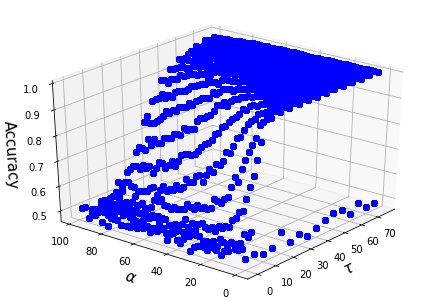

In [44]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.use('Qt4Agg')


fig1 = matplotlib.pyplot.figure()
ax1 = Axes3D(fig1)

ax1.set_xlabel(r"${\tau}$", fontsize=15)
ax1.set_ylabel(r"${\alpha}$", fontsize=15)
ax1.set_zlabel('Accuracy', fontsize=15)

# ax1.view_init(30, 210)
ax1.plot(10*x, 10*y, 10*z, 'ro', color='b', linewidth=3)

for angle in range(0, 220):
    ax1.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
plt.show()

### Smaller alpha values

In [46]:
tau_values = range(0, 80, 5)
alpha_values = np.around(np.arange(0, 1, 0.05), decimals=2)

In [47]:
scores_dict = {}

for tau in tau_values:
    scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))

In [ ]:
for tau in tau_values:
    for alpha in tqdm.tqdm(alpha_values):
#         print("Tau:", tau)
#         print("Alpha:", alpha)
#         print("Processing...")
        
        X, y = prepare_data(tau, alpha)
        pipelines = get_pipelines()

        scoring = {'accuracy' : make_scorer(accuracy_score)}
        scores = cross_validate(pipelines['kn'], X, y, scoring=scoring, cv=5)
        
        scores_dict[tau][alpha] = scores["test_accuracy"].mean()
#         print('______________________________________')
#         print()

 15%|█▌        | 3/20 [00:11<01:03,  3.74s/it]

In [37]:
save_obj(scores_dict, 'accuracy_scores_alpha_less_1')

In [38]:
x, y, z = [], [], []
for tau, alpha_dict in scores_dict.items():
    for alpha, accuracy in alpha_dict.items():
        x.append(tau)
        y.append(alpha)
        z.append(accuracy)

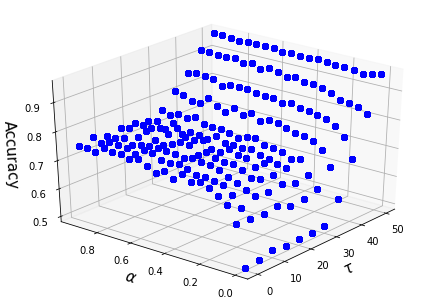

In [41]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.use('Qt4Agg')


fig1 = matplotlib.pyplot.figure()
ax1 = Axes3D(fig1)

# ax1.set_xlabel(r"$\dot{\tau}$")
ax1.set_xlabel(r"${\tau}$", fontsize=15)
ax1.set_ylabel(r"${\alpha}$", fontsize=15)
ax1.set_zlabel('Accuracy', fontsize=15)

ax1.view_init(40, 220)
ax1.plot(10*x, 10*y, 10*z, 'ro', color='b', linewidth=3)

for angle in range(0, 220):
    ax1.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

plt.show()